In [8]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.sandbox.regression.gmm import IV2SLS
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr

#!git clone https://github.com/ECMT-680-Financial-Econometrics/IV-Group-Slave-Trade.git

# Navigate to the repository directory
#%cd IV-Group-Slave-Trade

data = pd.read_csv('slave_trade_QJE_New_Data.csv')
# Preprocessing the data
data = data.drop(data.columns[[0,1]], axis=1) #Drop the first two columns

# Drop the columns that are not needed
columnstodrop = ['atlantic_distance_minimum_region_n_interaction', 'atlantic_distance_minimum_region_s_interaction', 'atlantic_distance_minimum_region_w_interaction', 'atlantic_distance_minimum_region_e_interaction', 'atlantic_distance_minimum_region_c_interaction', 'indian_distance_minimum_region_n_interaction', 'indian_distance_minimum_region_s_interaction', 'indian_distance_minimum_region_w_interaction', 'indian_distance_minimum_region_e_interaction', 'indian_distance_minimum_region_c_interaction', 'saharan_distance_minimum_region_n_interaction', 'saharan_distance_minimum_region_s_interaction', 'saharan_distance_minimum_region_w_interaction', 'saharan_distance_minimum_region_e_interaction', 'saharan_distance_minimum_region_c_interaction', 'red_sea_distance_minimum_region_n_interaction', 'red_sea_distance_minimum_region_s_interaction', 'red_sea_distance_minimum_region_w_interaction', 'red_sea_distance_minimum_region_e_interaction', 'red_sea_distance_minimum_region_c_interaction'] #Drop the first two columns
data = data.drop(columnstodrop, axis=1) 

# Preprocess the data
data = data.apply(pd.to_numeric, errors='coerce') #Convert all columns to numeric

# Scale non-binary columns for normalization
cols_to_scale = data.apply(lambda x: not pd.Series([0, 24]).isin(x).all())
data.loc[:, cols_to_scale] = scale(data.loc[:, cols_to_scale])

data = data.apply(lambda x: x.fillna(x.median()), axis=0)

# Define the dependent variable and instrumental variable
dependent_var = "ln_maddison_pcgdp2000"
instrumental_var = "ln_export_area"

# Separate the covariates and the dependent variable
X = data.drop(data.columns[0:24], axis=1)
y = data[dependent_var]
Z = data[instrumental_var]


# Perform Lasso to select important variables
lasso_y = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, y)
selected_y = X.columns[lasso_y.coef_ != 0]
print(selected_y)

lasso_z = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X.drop(columns=Z.name), Z)
selected_z = X.drop(columns=Z.name).columns[(lasso_z.coef_ != 0)]
print(selected_z)

# Get the indices of selected features
selected_vars = np.unique(np.concatenate([selected_y, selected_z]))
print(selected_vars)


Index(['ln_export_area', 'colony0', 'colony3', 'colony4', 'colony5', 'colony6',
       'abs_latitude', 'rain_min', 'low_temp', 'ln_coastline_area', 'islam',
       'region_c', 'ln_avg_oil_pop', 'ln_pop_dens_1400',
       'saharan_distance_minimum', 'red_sea_distance_minimum',
       'ethnic_fractionalization', 'land_area'],
      dtype='object')
Index(['ln_export_pop', 'colony1', 'colony3', 'colony6', 'colony7', 'rain_min',
       'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'region_n',
       'region_w', 'ln_avg_gold_pop', 'ln_avg_oil_pop',
       'ln_avg_all_diamonds_pop', 'ln_pop_dens_1400',
       'saharan_distance_minimum'],
      dtype='object')
['abs_latitude' 'colony0' 'colony1' 'colony3' 'colony4' 'colony5'
 'colony6' 'colony7' 'ethnic_fractionalization' 'islam' 'island_dum'
 'land_area' 'ln_avg_all_diamonds_pop' 'ln_avg_gold_pop' 'ln_avg_oil_pop'
 'ln_coastline_area' 'ln_export_area' 'ln_export_pop' 'ln_pop_dens_1400'
 'low_temp' 'rain_min' 'red_sea_distance_minimu

In [9]:
# Create a design matrix for regression
X_selected = data[selected_vars]
X_selected = X_selected.drop(columns=[instrumental_var])

# Perform 2SLS (Two-Stage Least Squares) using the instrumental variable
# First stage: Regress the instrumental variable with selected features
first_stage = sm.OLS(Z, sm.add_constant(X_selected)).fit()

print(first_stage.summary())


                            OLS Regression Results                            
Dep. Variable:         ln_export_area   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     129.0
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           1.82e-21
Time:                        12:22:57   Log-Likelihood:                 51.759
No. Observations:                  52   AIC:                            -51.52
Df Residuals:                      26   BIC:                           -0.7852
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [10]:
# Get predicted values from the first stage
Z_pred = first_stage.predict(sm.add_constant(X_selected))

# Second stage: Regress the dependent variable on the predicted values
second_stage = IV2SLS(y, sm.add_constant(X_selected), instrument=Z_pred).fit()

# Display the results
print(second_stage.summary())

                                     IV2SLS Regression Results                                      
Dep. Variable:     ln_maddison_pcgdp2000   R-squared:           -7603421372086034489988735827968.000
Model:                            IV2SLS   Adj. R-squared:     -14914403460630296863731880034304.000
Method:                        Two Stage   F-statistic:                                    4.490e-46
                           Least Squares   Prob (F-statistic):                                  1.00
Date:                   Wed, 24 Apr 2024                                                            
Time:                           12:23:10                                                            
No. Observations:                     52                                                            
Df Residuals:                         26                                                            
Df Model:                             25                                                   

c:\Python311\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 24
  warnings.warn('covariance of constraints does not have full '
c:\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [11]:
# Step 4: Conduct IV regression using the selected instruments and controls
iv_model = IV2SLS(y, sm.add_constant(data[Z.name]), data[selected_vars]).fit()

print(iv_model.summary())

                            IV2SLS Regression Results                            
Dep. Variable:     ln_maddison_pcgdp2000   R-squared:                      -0.233
Model:                            IV2SLS   Adj. R-squared:                 -0.257
Method:                        Two Stage   F-statistic:                     12.52
                           Least Squares   Prob (F-statistic):           0.000881
Date:                   Wed, 24 Apr 2024                                         
Time:                           12:23:20                                         
No. Observations:                     52                                         
Df Residuals:                         50                                         
Df Model:                              1                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [18]:
second_stage_variables = ['ln_maddison_pcgdp2000', 'gpd01', 'gdp02', 'gdp03', 'gdp04', 'gdp05', 'gdp06', 'gdp07', 'gdp08', 'gdp09', 'gdp10', 'gdp11', 'gdp12', 'gdp13', 'gdp14', 'gdp15','gdp16', 'gdp17', 'gdp18', 'gdp19', 'gdp20', 'gdp21', 'gdp22']
instrumental_var = "ln_export_area"

# Separate the covariates and the dependent variable
X = data.drop(data.columns[0:24], axis=1)
y = data[second_stage_variables]
Z = data[instrumental_var]
for dependent_variable in second_stage_variables:
    # Perform Lasso to select important variables
    lasso_y = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, data[dependent_variable])
    selected_y = X.columns[lasso_y.coef_ != 0]

    lasso_z = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, Z)
    selected_z = X.columns[(lasso_z.coef_ != 0)]

    # Get the indices of selected features
    selected_vars = np.unique(np.concatenate([selected_y, selected_z]))
    print(selected_vars)
    # Create a design matrix for regression
    X_selected = data[selected_vars]

    # Perform 2SLS (Two-Stage Least Squares) using the instrumental variable
    # First stage: Regress the instrumental variable with selected features
    first_stage = sm.OLS(Z, sm.add_constant(X_selected)).fit()
    # Get predicted values from the first stage
    Z_pred = first_stage.predict(sm.add_constant(X_selected))
    
    # Second stage: Regress the dependent variable on the predicted values
    iv_model = IV2SLS(data[dependent_variable], sm.add_constant(data[Z.name]), data[selected_vars]).fit()


['abs_latitude' 'colony0' 'colony3' 'colony4' 'colony5' 'colony6'
 'ethnic_fractionalization' 'islam' 'land_area' 'ln_avg_oil_pop'
 'ln_coastline_area' 'ln_export_area' 'ln_pop_dens_1400' 'low_temp'
 'rain_min' 'red_sea_distance_minimum' 'region_c'
 'saharan_distance_minimum']
['colony0' 'colony3' 'colony4' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_export_area' 'ln_pop_dens_1400' 'region_c']
['colony4' 'ln_avg_oil_pop' 'ln_coastline_area' 'ln_export_area'
 'ln_pop_dens_1400']
['colony0' 'colony1' 'colony3' 'colony4' 'colony5' 'colony7'
 'ln_avg_oil_pop' 'ln_coastline_area' 'ln_export_area' 'ln_pop_dens_1400'
 'region_c']
['abs_latitude' 'colony0' 'colony1' 'colony3' 'colony4' 'colony5'
 'colony7' 'ln_avg_oil_pop' 'ln_coastline_area' 'ln_export_area'
 'ln_pop_dens_1400' 'region_c']
['abs_latitude' 'colony0' 'colony1' 'colony3' 'colony4' 'colony5'
 'colony7' 'ln_avg_oil_pop' 'ln_coastline_area' 'ln_export_area'
 'ln_pop_dens_1400' 'region_c']
['colony0' 'colony4' 'colony5' 'ln_avg_oil_po

In [20]:
import pandas as pd

# Define an empty list to store the coefficients
coefficients_table = []

for dependent_variable in second_stage_variables:
    # Rest of the code remains the same as before

    # Fit the second stage regression
    iv_model = IV2SLS(data[dependent_variable], sm.add_constant(data[Z.name]), data[selected_vars]).fit()

    # Extract the coefficient of ln_export_area_predicted
    coefficient = iv_model.params['ln_export_area']

    # Store the coefficient along with the dependent variable name
    coefficients_table.append({'Dependent Variable': dependent_variable, 'Coefficient': coefficient})

# Create a DataFrame from the coefficients list
coefficients_df = pd.DataFrame(coefficients_table)

# Add a column representing years from 2000 to 2022
years = list(range(2000, 2023))
coefficients_df['Year'] = years

# Print the coefficients table
print(coefficients_df)


       Dependent Variable  Coefficient  Year
0   ln_maddison_pcgdp2000    -0.555496  2000
1                   gpd01    -0.481138  2001
2                   gdp02    -0.483787  2002
3                   gdp03    -0.478936  2003
4                   gdp04    -0.479416  2004
5                   gdp05    -0.479309  2005
6                   gdp06    -0.486500  2006
7                   gdp07    -0.490319  2007
8                   gdp08    -0.491115  2008
9                   gdp09    -0.491741  2009
10                  gdp10    -0.492523  2010
11                  gdp11    -0.502211  2011
12                  gdp12    -0.497352  2012
13                  gdp13    -0.482514  2013
14                  gdp14    -0.483786  2014
15                  gdp15    -0.486879  2015
16                  gdp16    -0.493264  2016
17                  gdp17    -0.490833  2017
18                  gdp18    -0.493515  2018
19                  gdp19    -0.493168  2019
20                  gdp20    -0.483483  2020
21        

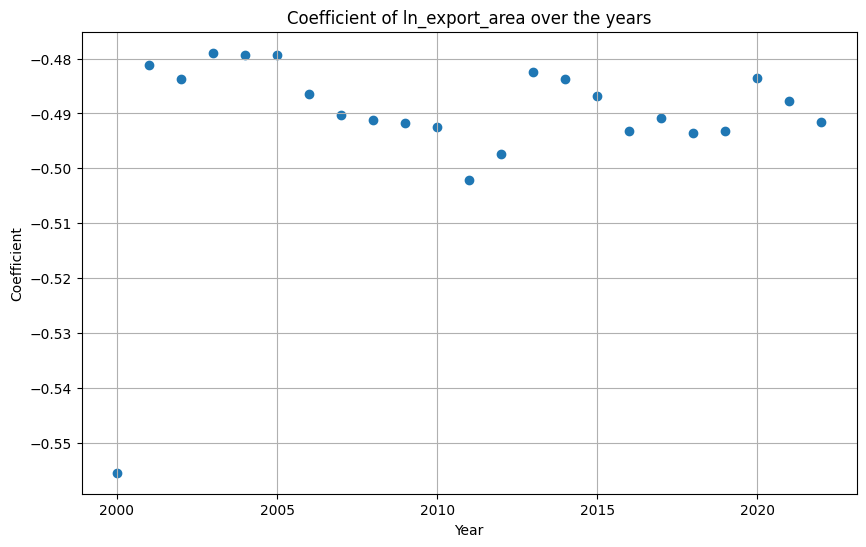

In [21]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot coefficients for each dependent variable
plt.scatter(coefficients_df['Year'], coefficients_df['Coefficient'])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Coefficient of ln_export_area over the years')
plt.grid(True)

# Show plot
plt.show()